## 2) Implementación del Modelo

Ingreso de Módulos:

In [1]:
!(pip install scikit-learn)
!(pip install tensorflow)
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import joblib as jb

2023-09-27 06:07:23.449823: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 06:07:23.490637: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 06:07:23.491673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 06:07:24.198405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Modulo propio
import naive_bayes_mnist

### Cargamos los datos

In [5]:
shape_train=[int(i) for i in np.loadtxt('shape_train.csv')]
shape_test=[int(i) for i in np.loadtxt('shape_test.csv')]
x_train_p=np.reshape(mnist.load_data()[0][0],(shape_train[0],shape_train[1]*shape_train[2])) #pd.read_csv('x_train.csv',names=np.arange(shape_train[1]*shape_train[2]))
y_train=pd.read_csv('y_train.csv',names=[0])[0]
x_test_p=pd.read_csv('x_test.csv',names=np.arange(shape_test[1]*shape_train[2]))
y_test=pd.read_csv('y_test.csv',names=[0])[0]
print('X_train: ',x_train_p.shape) # Indices: (Imagen i, fila j, columna k)
print('Y_train: ',y_train.shape)
print('X_test:  ',x_test_p.shape)
print('Y_test:  ',y_test.shape)

X_train:  (60000, 784)
Y_train:  (60000,)
X_test:   (10000, 784)
Y_test:   (10000,)


In [6]:
x_train=np.reshape(x_train_p,shape_train)
x_test=np.reshape(x_test_p.values,shape_test)

### Primer intento con los Módulos de Scikitlearn

Inicialmente intentamos con las funciones previamente implementadas de scikitlearn. Sin embargo, estas funciones reciben de entrada listas bidimensionales (nx1) por lo que ingresamos las imágenes planas. Sin embargo veremos que los resultados no fueron los mejores

In [7]:
nb_classifier = GaussianNB() #asumimos una distribución normal de los pixeles
nb_classifier.fit(x_train_p, y_train) # ajuste del modelo
y_pred = nb_classifier.predict(x_test_p) # valores predichos

Ejemplo de uno de los valores predichos

Valor predicho:  9


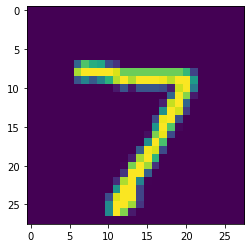

In [8]:
print("Valor predicho: ",y_pred[0])
plt.imshow(x_test[0])

In [9]:
accuracy = accuracy_score(y_test, y_pred)
print("Puntos etiquetados erróneamente de %d puntos : %d"
      % (x_test_p.shape[0], (y_test != y_pred).sum()))
print("Exactitud: ",accuracy)

Puntos etiquetados erróneamente de 10000 puntos : 4442
Exactitud:  0.5558


Vemos que el modelo tiene una exactitud del 55.58%, que no será tan buena como la que obtendremos al realizarlo manualmente.

### Naive Bayes Manual

Asumimos que en cada pixel la versimilitud sigue una distribución normal. Calculamos la probabilidad de que cada píxel en cada imagen de testeo corresponda al píxel promedio de un número dado (Función de verosimilitud o likelihood). Luego hallamos el dígito correspondiente a la máxima probabilidad.

En otras palabras, la verosimilitud de que la imagen $X_i$ corresponda con la característica/etiqueta $C_l$ se debe comparar pixel a pixel (pixeles independientes entre sí), de modo que viene dada por:

$$P(X_i| C_l)= \prod_{i=1}^{28\times28}\frac{1}{\sqrt{2\pi\sigma_i^2}} \exp{\left [ -\frac{(X_i-\mu_i)^2}{2\sigma_i^2}\right ]} $$

y la probabilidad de que sea $C_l$ es:
$$ P(C_l)=P(X_i| C_l)P(X_i)$$

Aplicamos log y sacamos el argumento (la inversa) para hallar $C_l$ que es la característica que queremos predecir de $X_i$:

$$ C_l=argmax(\log P(X_i| C_l)+\log P(X_i))$$
Vemos que $C_l$ aumenta con $P(X_i| C_l)$ y $P(X_i)$ por lo tanto solo hallaremos en el programa $\log P(X_i| C_l)$.

Hallamos los parámetros mu y sigma para cada imagen a partir de los datos de entrenamiento

Promedios del entrenamiento


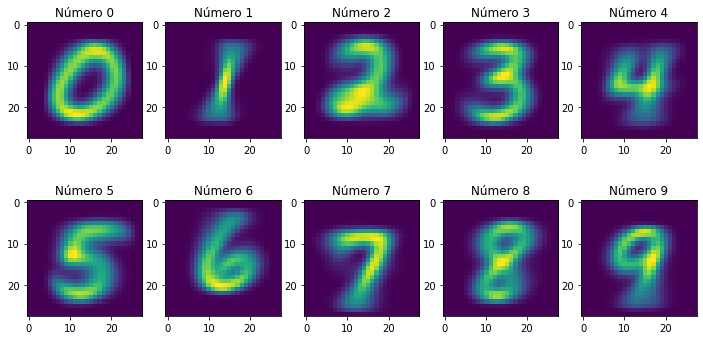

In [10]:
av,sigma=naive_bayes_mnist.estadisticos(x_train,y_train)
print("Promedios del entrenamiento")
fig, axs = plt.subplots(2, 5,figsize=(12, 6))
# Plot something in each subplot
for i, ax in enumerate(axs.flat):
    ax.imshow(av[i], label=f'Plot {i+1}')
    ax.set_title(f'Número {i}')

plt.show()


Método naive bayes para encontrar las características

In [11]:
# y_pred=naive_bayes_mnist(x_train,y_train,x_test)
model=naive_bayes_mnist
y_pred,prob=model.nb_mnist(x_train,y_train,x_test)

Ejemplo de algunas predicciones


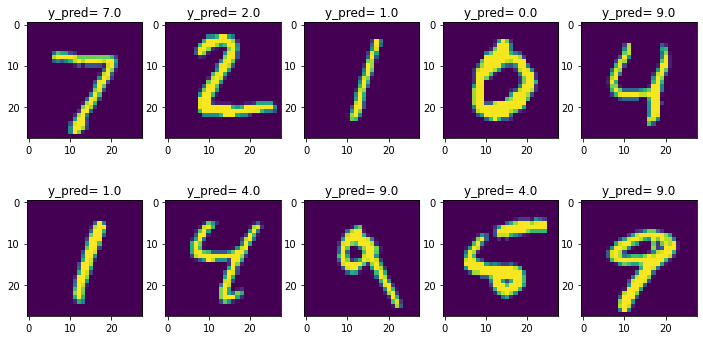

In [12]:
print("Ejemplo de algunas predicciones")
fig, axs = plt.subplots(2, 5,figsize=(12, 6))
# Plot something in each subplot
for i, ax in enumerate(axs.flat):
    ax.imshow(x_test[i])
    ax.set_title(f'y_pred= {y_pred[i]}')

plt.show()

## 3) Desempeño de Generalización del Problema de Clasificación (problem generalization performance)

In [13]:
print("Puntos etiquetados erróneamente de %d puntos : %d"
      % (x_test_p.shape[0], (y_test != y_pred).sum()))

Puntos etiquetados erróneamente de 10000 puntos : 2619


### Resultados de Principales Métricas de Clasificación

Cada fila en la tabla corresponde a una clase diferente, e incluye varias métricas para cada clase y el rendimiento general del modelo.

In [14]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = pd.DataFrame.from_dict(classification_report(y_test, y_pred,output_dict=True)).transpose()
print(f"Accuracy: {accuracy}")
report

Accuracy: 0.7381


,precision,recall,f1-score,support
0,0.905528,0.919388,0.912405,980.0000
1,0.762958,0.972687,0.855151,1135.0000
2,0.923430,0.584302,0.715727,1032.0000
3,0.797632,0.733663,0.764312,1010.0000
4,0.862888,0.480652,0.617397,982.0000
5,0.876607,0.382287,0.532397,892.0000
6,0.773124,0.924843,0.842205,958.0000
7,0.931701,0.703307,0.801552,1028.0000
8,0.531056,0.702259,0.604775,974.0000
9,0.506011,0.917740,0.652342,1009.0000


Desglosemos las métricas clave:

- **Precisión** (Precision): Modelo logra una alta precisión en la mayoría de las clases, lo que significa que la mayoría de las instancias predichas como pertenecientes a esas clases son realmente correctas. Por ejemplo, para la Clase 0, la precisión es del 90.55%, lo que indica que el 90.55% de las instancias predichas como Clase 0 son correctas.

- **Recuperación** (Recall): El modelo también logra una alta recuperación en la mayoría de las clases, lo que significa que identifica correctamente la mayoría de las instancias reales de esas clases. Por ejemplo, para la Clase 1, la recuperación es del 97.27%, lo que indica que el 97.27% de las instancias reales de la Clase 1 son identificadas correctamente.

- **Puntaje F1** (F1-score): El puntaje F1 de Modelo es alto en la mayoría de las clases, lo que demuestra un equilibrio entre precisión y recuperación. Por ejemplo, para la Clase 2, el puntaje F1 es del 71.57%, lo que indica un buen equilibrio entre la capacidad de clasificar correctamente y la identificación de instancias reales.

- **Soporte**: El soporte representa el número de ocurrencias reales de cada clase en el conjunto de datos. Modelo 1 tiene soportes significativos para todas las clases, lo que indica que se ha evaluado en un conjunto de datos diverso.

- **Exactitud** (Accuracy): La exactitud general de Modelo es del 73.81%, lo que significa que predice correctamente el 73.81% de las instancias en el conjunto de datos. Además si lo comparamos con el primero intento, vemos que la exactitud es mucho mejor (comparada con el 55.58%)

En resumen, Modelo  demuestra un buen rendimiento en la mayoría de las clases, con altos valores de precisión, recuperación y puntaje F1. Esto sugiere que el modelo es efectivo en la clasificación de las instancias y logra un equilibrio entre la precisión y la capacidad para identificar las instancias reales en el problema de clasificación multiclase.

### Matriz de Confusión

Esta es la matriz de confusión para el problema de reconocimiento de dígitos, donde cada fila representa una clase de dígito (0-9) y cada columna representa las predicciones del modelo para esas clases. Los números en la matriz indican la cantidad de instancias clasificadas en cada categoría. Aquí están las observaciones:


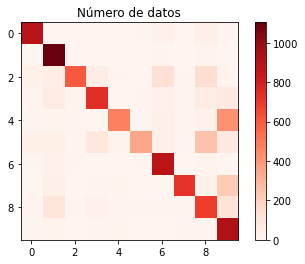

In [15]:
plt.imshow(confusion_matrix(y_test,y_pred),cmap='Reds')
plt.title("Número de datos")
plt.colorbar()

```
Matriz de Confusión:

            Actual
          0  1  2  3  4  5  6  7  8  9
Predicho
  0     901   1   2   1   2   5  23   1  35   9
  1       0  1104   2   3   0   0   6   0  18   2
  2      26   46  603  55  10   0 126   8 145  13
  3      11   57  15  741   2   9  25  12  68  70
  4       5   14   6   2  472   9  33   5  25 411
  5      31   43   6  87  18  341  33   9 250  74
  6       7   24   6   1   3  12 886   0  18   1
  7       0   32   4   8  14   1   4 723  27 215
  8       9  106   5  24   9  12  10   6 684 109
  9       5   20   4   7  17   0   0  12  18 926
```
- En la diagonal principal, se observan los números de instancias que fueron clasificadas correctamente. Por ejemplo, en la celda (0, 0), se clasificaron correctamente 901 instancias como clase 0.

- Fuera de la diagonal principal, se encuentran las instancias en las que el modelo cometió errores de clasificación. Por ejemplo, en la celda (2, 7), hay un valor de 8, lo que indica que 8 instancias de la clase 2 se clasificaron incorrectamente como clase 7.

- Las filas representan las clases reales (ground truth), y las columnas representan las predicciones del modelo.

- Se puede observar cómo el modelo se desempeña en cada clase y dónde tiende a cometer errores con mayor frecuencia. Por ejemplo, parece que el modelo tiene dificultades para distinguir entre las clases 2 y 8, ya que hay varios errores en esas celdas.

- Esta matriz de confusión es una herramienta valiosa para evaluar el rendimiento del modelo y comprender dónde se necesitan mejoras. Puede ser útil para ajustar el modelo o tomar decisiones sobre estrategias específicas para mejorar la clasificación en clases problemáticas.

In [16]:
jb.dump(model.nb_mnist, "./model")

['./model']

In [17]:
# jb.dump(x_train, "./x_train_copy")
jb.dump(y_train, "./y_train_copy")

['./y_train_copy']